## Identifying Supernova Neutrinos with Machine Learning
This is an improved version of SNEWSproject.ipynb, where I've retroactively applied tuning to optimise the CNN architectures.

The aims of the notebook remain the same, as:
1. Write function to add simulated electronic noise to clean neutrino data slices, or empty slices. 
2. Develop a CNN classifier which can successfully classify clean neutrino slices from empty slices.
3. Test CNN classifier on simulated neutrinos overlaid with noise. 

Extension tasks included:
1. Write function to add simulated radioactive noise, which takes the form of randomly placed Gaussian 'blobs' with appropriate energy. Discern whether radioactive noise or electronic noise is more problematic.


In [1]:
#  First import required modules
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import keras_tuner as kt

# Check library versions
print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)

Matplotlib is building the font cache; this may take a moment.
2025-06-28 19:59:32.680627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow Version: 2.16.2
NumPy Version: 1.26.4


In [2]:
# Now load simulated data from neutrino detectors
images=np.load('larImages.npy')
meta=np.load('meta.npy')

# Check data dimensions
print("images.shape",images.shape)
print("meta.shape",meta.shape)
print("")

# Confirm order of data within the multidimensional variables
print("Verification sentence: Row",int(meta[0][0]),"corresponds to a neutrino of",meta[0][1], "MeV and produced",int(meta[0][3]),"final state particles")

images.shape (10000, 100, 100)
meta.shape (10000, 64)

Verification sentence: Row 0 corresponds to a neutrino of 21.2005 MeV and produced 6 final state particles


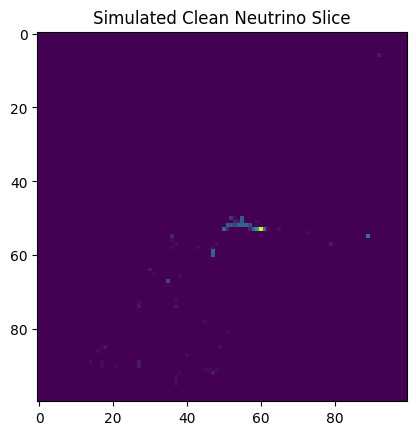

In [3]:
# Visualising an image slice without any added interference 
plt.figure()
plt.imshow(images[0])
plt.title('Simulated Clean Neutrino Slice')
plt.show()

## Section 1: Noise function
Each 2D image is 100x100 pixels. A function will be made to take a set of input images, and add normally-distributed noise across it. If the input variable 'empty' is true, empty data slices will be generated with noise.

Noise will follow a Gaussian distribution centered at 0, with standard deviation 'stdev'. The absolute value is taken and applied as noise as the interference intensity cannot be negative. The stdev value affects the noise intensity.

In [4]:
# Define noise function
def add_noise(rawData,stdev,noiseInlaid=False,random=False):
    '''
    '''
    # If false, generate data with 'stdev' of noise spread
    if random == False:
        # Generates Gaussian-noise centered at 0, with standard deviation stdev
        # Electrical signal cannot be negative, hence the absolute value is taken
        noise = np.abs(stdev * np.random.randn(rawData.shape[0],rawData.shape[1],rawData.shape[2]))
        print(np.shape(noise))
    # If true, treat stdev as an upper limit, 0.5 as lower limit and randomly distribute 'stdev' spread for each image
    else:
        noise=np.empty((10000,100,100))
        # Iterate through each image to apply a random stdev value for noise
        for i in range(rawData.shape[0]):
            # Generate a new random stdev value for each image
            current_stdev = np.random.uniform(0.5, stdev)
            
            # Generate noise for this single image using its unique stdev
            current_noise = np.abs(current_stdev * np.random.randn(rawData.shape[1],rawData.shape[2]))
            # Add the generated noise to the corresponding image in the output array.
            noise[i] += current_noise

    # If statement to determine if data is included in output (task3)
    if noiseInlaid == False:
        # Returns empty noise slice
        return noise
    else:
        # Returns data overlaid with noise
        return (rawData + noise)

<b>Visualising Noise on Slices</b><br>
Now we observe the effects of different intensities of noise on the data slices, between 0-10 st. dev. The first neutrino slice from the 'images' array is used as an example.

(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)


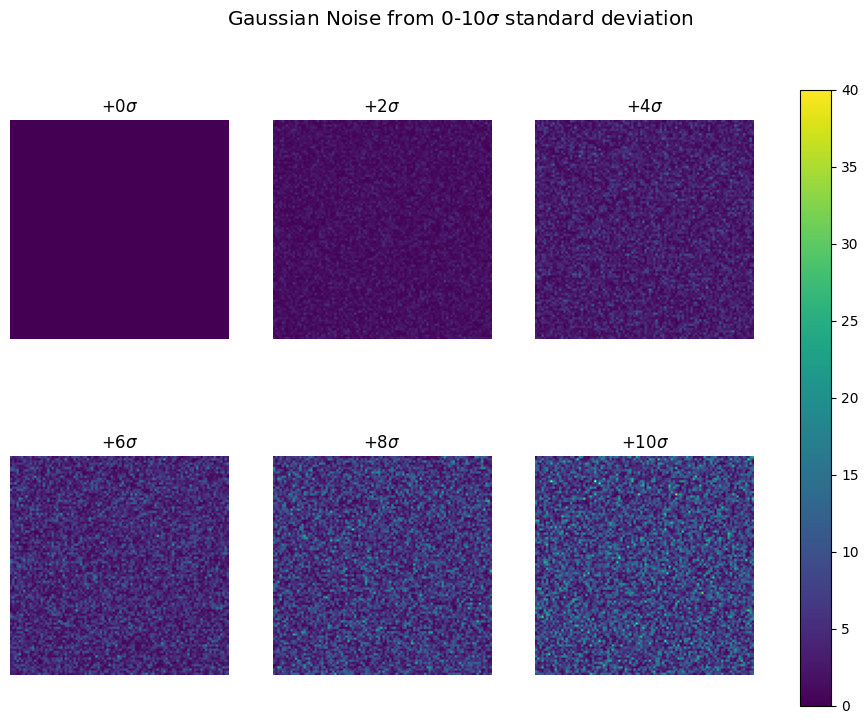

In [5]:
stdev = 0  # starts at 0 sigma

# Figure with 2 columns, 3 rows of subplots
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

# Loop through subplots, generate noisy images, and plot, increasing sigma each loop
for ax in axes.flat:
    noisy_image = add_noise(images,stdev)
    im = ax.imshow(noisy_image[0],vmin=0,vmax=40)
    
    # Stylisation, titles
    ax.set_title('+'+str(stdev)+r'$\sigma$')
    ax.axis('off')
    stdev+= 2
    
fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle(r'Gaussian Noise from 0-10$\sigma$ standard deviation',fontsize='x-large')
plt.show()
        

### Observations
Visually, noise becomes prominent at 4$\sigma$ and above. At 10$\sigma$, the neutrino intensity peak is no longer distinguishable by eye. It must be noted that this is only for the case of images[0], and different slices carry varying recorded intensities. 

In the cell below, the data files are skimmed through to find the maximum intensity across all clean neutrino images, as well as the average.

In [6]:
# Find average maximum intensity per image across all images
max_int_per_image = np.empty(np.shape(images)[0])

for i in range(np.shape(images)[0]):
    max_int_per_image[i] = np.amax(images[i])

# Find maximum intensity and corresponding image index across all images
max_int = np.amax(images)
max_image = str(np.argmax(images))

print(f'Maximum intensity recorded across all images is {max_int} on image no. {max_image[:3]}.')
print(f'Lowest intensity recorded across all images is {np.amin(max_int_per_image)} on image no. {str(np.argmin(max_int_per_image))}.')
print(f'Average maximum intensity across all images is {np.average(max_int_per_image)}.')
print(f'')

# Find standard deviation (absolute spread) of maximum intensities across images around the average
std_dev_max_intensity = np.std(max_int_per_image)

print(f'Standard deviation of maximum intensities is {std_dev_max_intensity:.2f}.')
print(f'')

# Calculate average peak intensities of noised images from +2-10 sigma
sigma = [2,4,6,8,10]
noise_max_int = np.empty(np.shape(images)[0])
noise_avg_int = np.empty_like(sigma)

for i in sigma:
    empty_noise = add_noise(images,i)
    for j in range(np.shape(images)[0]):
        noise_max_int[j] = np.amax(empty_noise[j])
    noise_avg_int[int((i/2)-1)] = np.average(noise_max_int)

print(f'Average maximum intensity of empty noise for:')
print(f'+2  st.dev : {noise_avg_int[0]}')
print(f'+4  st.dev : {noise_avg_int[1]}')
print(f'+6  st.dev : {noise_avg_int[2]}')
print(f'+8  st.dev : {noise_avg_int[3]}')
print(f'+10 st.dev : {noise_avg_int[4]}')

Maximum intensity recorded across all images is 106.0 on image no. 462.
Lowest intensity recorded across all images is 7.0 on image no. 5872.
Average maximum intensity across all images is 25.6761.

Standard deviation of maximum intensities is 9.84.

(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)
(10000, 100, 100)
Average maximum intensity of empty noise for:
+2  st.dev : 8
+4  st.dev : 16
+6  st.dev : 24
+8  st.dev : 32
+10 st.dev : 40


With an average maximum intensity of 25.7, and a standard deviation of 9.84, the deposited energy exhibits great variability. Considering this, it may be necessary to train the classifier for noise ranging from between 2-8$\sigma$ as intensities above 10$\sigma$ may prove too large. 

## Section 2: CNN Classification - Clean neutrino data, or empty noise slice?
A CNN algorithm is developed to discern clean neutrino data from empty noise slices. There are 10,000 instances in 'images'. An additional 10,000 empty noise slices will be produced and mixed in with the 'images' arrays. Each noise slice will have a random indensity between 0.5-8$\sigma$. 

The range 0-0.5$\sigma$ is omitted as selecting zero will result in an empty slice. The range 0.1-0.5 should be low enough such that denoising specialisation is not required, seeing as average maximum intensities are 25.7 with 9.84 standard deviation.

A common method to split data is 80/10/10, where 80% is used for training, 10% for validation and 10% for testing. The same will be used in this case. Each slice will be labelled '1' for neutrino activity, and '0' for empty noise.


In [7]:
# Function creates training, validation and testing datasets for CNN development
def generateData(rawData,stdev,noiseInlaid=False,random=False,radiation=False):
    '''
    rawData:          Raw training dataset
    stdevUpperLimit:  Upper limit of standard deviation to be applied to noise
    noiseInlaid:      Boolean for whether noise is to be added to neutrino event slices
    random:           Boolean. If true, stdev value is treated as an upper limit and randomly selected
                      between 0.5-value for each image slice.
    radiation:        Boolean. If true, generates radiation following section 4 below.
    '''
    # These are constants set for radiation, which is addressed in section 4. They are set as variables so they can be changed if needed
    argon_intensity_range= [0.003,0.019]
    argon_rate= 195.5
    argon_spot_spread= 2
    radon_intensity_range= [0.01,0.327]
    radon_rate= 0.07
    radon_spot_spread= 2

    
    if radiation == True:
        rawData = add_radioactive_noise(images, argon_intensity_range, argon_rate, argon_spot_spread, radon_intensity_range, radon_rate, radon_spot_spread)

    # If false, neutrino event slices will be unaffected, and noise concatenated to the training data
    if noiseInlaid == False:
        # Concatenate raw data with empty noise arrays to create training, test and validation data
        all_images = np.concatenate((rawData,add_noise(rawData,stdev,noiseInlaid=noiseInlaid,random=random)))
        all_labels = np.concatenate((np.ones(np.shape(rawData)[0]),np.zeros(np.shape(rawData)[0])))
    else:
        # Adds noise to all neutron data, concatenates with empty noise samples
        all_images = np.concatenate((add_noise(rawData,stdev,noiseInlaid=noiseInlaid,random=random),add_noise(rawData,stdev,noiseInlaid=noiseInlaid,random=random)))
        all_labels = np.concatenate((np.ones(np.shape(rawData)[0]),np.zeros(np.shape(rawData)[0])))
    
    # Shuffle images and labels together
    shuffle_images,shuffle_labels = shuffle(all_images,all_labels)
    
    # Divide data into training, test and validation data following [0.8,0.1,0.1] split
    train_images,val_images,test_images = np.split(shuffle_images,[int(len(shuffle_images)*0.8),int(len(shuffle_images)*0.9)])
    train_labels,val_labels,test_labels = np.split(shuffle_labels,[int(len(shuffle_labels)*0.8),int(len(shuffle_labels)*0.9)])
    
    # Rescale images to 0-1 (peak intensity is 106)
    train_images = train_images / 106.0
    val_images   = val_images  / 106.0
    test_images  = test_images/ 106.0
    
    # Vectorise labels for binary cross-entropy
    #train_labels = np.asarray(train_labels).astype('float32').reshape((-1,1))
    #val_labels = np.asarray(val_labels).astype('float32').reshape((-1,1))
    #test_labels = np.asarray(test_labels).astype('float32').reshape((-1,1))
    
    return train_images,val_images,test_images,train_labels,val_labels,test_labels

Visualising the data:

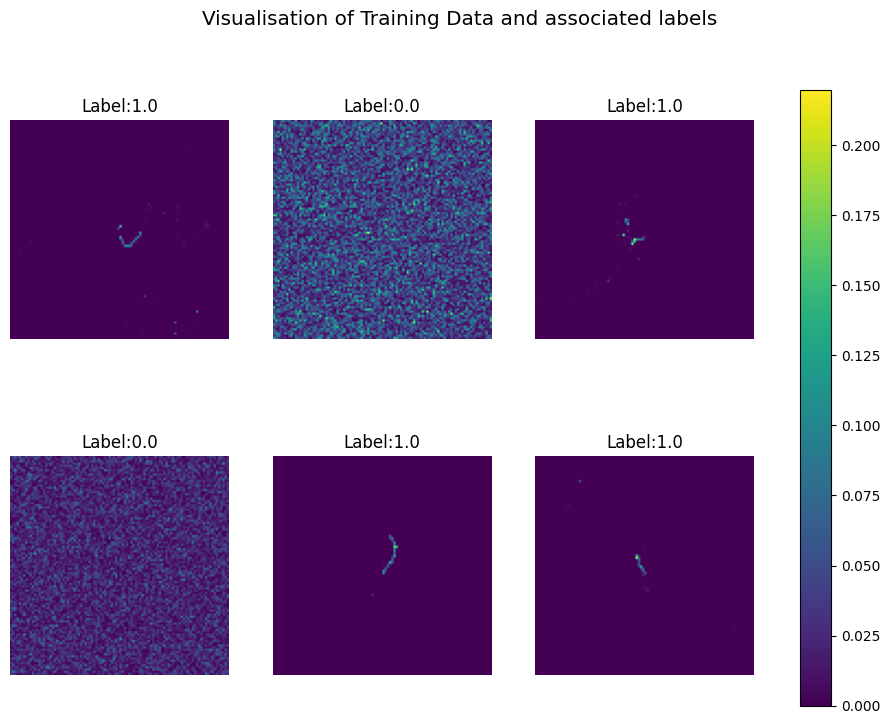

Maximum intensity recorded across all images is 0.9716981132075472 on image no. 600.
Lowest intensity recorded across all images is 0.02 on image no. 14747.
Average maximum intensity across all images is 0.20.

Standard deviation of maximum intensities is 0.10.



In [8]:
# Call data function to generate data, with random noise from 0.5-8 stdev
train_images,val_images,test_images,train_labels,val_labels,test_labels = generateData(images,8,noiseInlaid=False,random=True)

# Plot 6 random training images and associated labels (1=neutron,0=noise)
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))

for ax in axes.flat:
    # Generate random index from train_images and plot
    i = random.choice(range(np.shape(train_images)[0]))
    im = ax.imshow(train_images[i],vmax=0.22)
    ax.set_title(f'Label:{train_labels[i]}')
    ax.axis('off')
fig.colorbar(im,ax=axes.ravel().tolist())
fig.suptitle('Visualisation of Training Data and associated labels',fontsize='x-large')
plt.show()

# Find average maximum intensity per image across all images
max_int_per_image = np.empty(np.shape(train_images)[0])

for i in range(np.shape(train_images)[0]):
    max_int_per_image[i] = np.amax(train_images[i])

# Find maximum intensity and corresponding image index across all images
max_int = np.amax(train_images)
max_image = str(np.argmax(train_images))

print(f'Maximum intensity recorded across all images is {max_int} on image no. {max_image[:3]}.')
print(f'Lowest intensity recorded across all images is {np.amin(max_int_per_image):.2f} on image no. {str(np.argmin(max_int_per_image))}.')
print(f'Average maximum intensity across all images is {np.average(max_int_per_image):.2f}.')
print(f'')

# Find standard deviation (absolute spread) of maximum intensities across images around the average
std_dev_max_intensity = np.std(max_int_per_image)

print(f'Standard deviation of maximum intensities is {std_dev_max_intensity:.2f}.')
print(f'')

## Defining a CNN architecture
Two questions arise at this point: what network architecture to use, and how to tweak the model parameters? Manually tweaking model parameters-- no. of layers, learning rate, filter sizes-- is time-consuming and inefficient. 

### Tuners
Fortunately, the Keras Tuner library has optimisation algorithms to streamline this process. Two relevant algorithms include:
1. <b>Bayesian Optimisation</b>: Design-of-Experiment style algorithm where each trial is used to inform a probabilistic model of the relationship between hyperparameters and performance. This allows the algorithm to focus its next trial on the most promising areas of parameter space, significantly reducing number of evaluations required [iqbal],[jones].
2. <b>Hyperband:</b>: A bandit-based algorithm approaching optimisation like a tournament, training multiple models for a few epochs and discarding poor performers, allocating more resources to promising candidates. This makes the algorithm highly cost effective [li 2018],[yang and shami]. 

However, it is difficult to choose between the two algorithms, as they offer different strengths. Hyperband, although efficient, is quick to discard model configurations. If some model configurations are slow to converge on the strongest values, Hyperband may prematurely eliminate the best long-term performers.

Bayesian Optimisation, on the other hand, runs each trial for the full number of specified epochs and will likely be more robust and reliable. Thus, in the application of SNEWS where false positives and/or missed supernova neutrinos can be detrimental, Bayesian Optimisation is likely to be a stronger option.

For thoroughness sake, both tuners will be tried and compared to develop the strongest classifier.

### Hyperparameter Ranges
Each tuner algorithm will search through the hyperparameter ranges to develop a set of optimal model parameters. It is therefore important to establish intentional ranges to ensure each hyperparameter remains within recommended values.

***1. Convolutional Blocks (Feature Extraction Layer)***

- **no. of blocks**
    : Each convolutional block increases the level of abstraction from the classifier. Having a range of blocks tested tests whether a deeper network is necessary identify more complex features, or if a shallower network is sufficient and less prone to overfitting [nvidia developer].<br>
- **filters**
    : A range between 32, 64, 96 and 128 is a standard and effective selection for image classification, similar to VGGNet and ResNet, which are common architectures used. At 32 filters, the model is able to learn simple features such as edges, while higher filters allow identification of more complex features. A maximum of 128 allows the model to have enough capacity whilst maintaining a reasonable size [maheshwari].<br>
- **kernel size**
    : Fixed at 3x3, as it is known that 3x3 layers provide a larger receptive field with fewer parameters than using less 5x5 of 7x7 kernels, which are also costlier [How to optimize Convolutional Layer with Convolution Kernel].<br>
- **padding**
    : 'Same' padding ensure the convolutional layer output has the same dimensions as the input. This prevents the feature maps diminishing in size and allows for effective deeper networks [mishra,miyank].<br>
- **activation function**
    : 'ReLU' or Rectified Linear Unit is the most popular and effective choice for deep learning models, mitigating the vanishing gradient problem [ramachandran].<br>

***2. Classification Block***

- **dense layer units**
    : Ranging between 64 to 256 provides sufficient capacity to learn complex relationships without being excessively large, which can be computationally expensive and lead to overfitting [ghosh]<br>
- **dropout rate**
    : Regularisation technique to prevent overfitting, randomly setting a fraction of neuron activations to zero during training. A range of 20-50% is standard [srivastava].<br>
    
***3. Compilation Parameters***

- **optimizer**
    : Adam is the go-to optimiser for most deep learning applications, being computationally efficient and applicable to a range of problems [kingma and ba].<br>
- **learning rate**
    : The range 0.001 to 0.0001 is a generally acceptable range for the Adam optimiser, allowing for stable convergence [kandel].

In [9]:
def build_classifier(hp):
    """Builds a tunable CNN classifier."""
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(100, 100, 1)))

    # --- Feature Extraction Blocks ---
    # Looping to build a series of convolutional blocks. The number of blocks itself
    # is also a hyperparameter, allowing for tuning of model depth.
    for i in range(hp.Int('num_conv_layers',2,4)):
        model.add(keras.layers.Conv2D(
            # Tune no. of filters for Conv2D layer in this block
            filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=3,
            padding='same',      # Maintain feature map size before pooling
        ))
        model.add(keras.layers.BatchNormalization())      # Batch normalisation for stablising training
        model.add(keras.layers.Activation('relu'))        
        model.add(keras.layers.MaxPooling2D(pool_size=2)) # Max pooling after each layer to downsample
    
    # --- Classification ---
    model.add(keras.layers.Flatten())
    
    # Dense layer for learning from extracted features
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(keras.layers.Dense(units=hp_units))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
    # Tuning dropout to prevent overfitting
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout))
    
    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Tune learning rate for optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    
# Initialise Hyperband tuner
tuner_hb = kt.Hyperband(
    build_classifier,
    objective='val_accuracy',
    max_epochs=3,                  # max no. of epochs to train a model
    factor=3,
    directory='tuner_comparison',   # shared directory for tuners
    project_name='hyperband'
)

# Initialise Bayesian Optimization tuner
tuner_bo = kt.BayesianOptimization(
    build_classifier,
    objective='val_accuracy',
    max_trials=3,                  # how many different hyperparameter combinations to test
    directory='tuner_comparison',
    project_name='bayesian_optimization'
)


Reloading Tuner from tuner_comparison/hyperband/tuner0.json
Reloading Tuner from tuner_comparison/bayesian_optimization/tuner0.json


## Training 
Now, we can run a hyperparameter search using each tuner, train each model on the training, validation and testing data from 'generateData()' and compare results.

Firstly, generating data. Noise will be from 0.5-8 stdev spread:

In [10]:
train_images,val_images,test_images,train_labels,val_labels,test_labels = generateData(images,8,noiseInlaid=False,random=True)

Tuning parameters and comparing:

In [11]:
epochs = 3     # in-depth search is not required at the moment as dataset is easy to discern

# Run a hyperparameter search for each tuner
#print("\n--- Bayesian Optimization Parameter Search ---")
#tuner_bo.search(train_images, train_labels, epochs=epochs, validation_data=(val_images,val_labels)) # BO
print("\n--- Hyperband Parameter Search ---")
tuner_hb.search(train_images, train_labels, epochs=epochs, validation_data=(val_images,val_labels)) # HB

# Comparing results
print("\n\n--- RESULTS SUMMARY ---")
#print("\n--- Bayesian Optimization: ---")
#tuner_bo.results_summary()
print("\n--- Hyperband: ---")
tuner_hb.results_summary()

# Extract best model from each tuner
print("\n\n--- MODEL EVALUATION ---")
#best_model_bo = tuner_bo.get_best_models(num_models=1)[0]
#bo_loss, bo_accuracy = best_model_bo.evaluate(x_test, y_test)
#print(f"Best Model (Bayesian Optimization) Test Accuracy: {bo_accuracy:.4f}")

best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
hb_loss, hb_accuracy = best_model_hb.evaluate(x_test, y_test)
print(f"Best Model (Hyperband) Test Accuracy: {hb_accuracy:.4f}")

Trial 29 Complete [01h 50m 11s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 4d 02h 25m 40s


--- RESULTS SUMMARY ---

--- Hyperband: ---
Results summary
Results in tuner_comparison/hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0021 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 128
filters_1: 32
units: 256
dropout: 0.2
learning_rate: 0.001
filters_2: 64
filters_3: 64
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0

Trial 0018 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 96
filters_1: 64
units: 64
dropout: 0.30000000000000004
learning_rate: 0.0001
filters_2: 128
filters_3: 128
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0

Trial 0005 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 64
filters_1: 32
units: 192
dropout: 0.2
learning_rate: 0.001
filters_2: 32
filters_3: 96
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tun

NameError: name 'x_test' is not defined

It is evident that this kind of ML architecture, using both Hyperband and Bayesian Optimisation tuners, is capable of image classification at this difficulty - that is without the presence of inlaid noise. We can now consider inlaid noise and maximising the noise to stress test these algorithms.

## Section 3: CNN Classification - Simulated neutrinos inlaid with noise
Now that we've proven the architecture supports this type of image classification, we'll now alter the training data such that:
1. Noise will be inlaid with neutrino events, such that all training data, negative or positive, will have a gaussian background noise (simulating electronic interference) of between 0.5-8$\sigma$.

If the algorithm is easily able to classify neutrino events under these conditions, the noise range will be further increased.

In [ ]:
train_images,val_images,test_images,train_labels,val_labels,test_labels = generateData(images,8,noiseInlaid=True,random=True)

# Visualising inlaid noise to ensure correct data has been generated
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))

for ax in axes.flat:
    # Generate random index from train_images and plot
    i = random.choice(range(np.shape(train_images)[0]))
    im = ax.imshow(train_images[i],vmax=0.22)
    ax.set_title(f'Label:{train_labels[i]}')
    ax.axis('off')
fig.colorbar(im,ax=axes.ravel().tolist())
fig.suptitle('Visualisation of Training Data and associated labels',fontsize='x-large')
plt.show()

Seeing as the data appears correct, we can begin a new hyperparameter search and model training for the inlaid data.

In [ ]:
epochs = 3    # data is relatively low-difficulty. not many epochs required to attain 100% accuracy

# Run a hyperparameter search for each tuner
#print("\n--- Bayesian Optimization Parameter Search ---")
#tuner_bo.search(train_images, train_labels, epochs=epochs, validation_data=(val_images,val_labels)) # BO
print("\n--- Hyperband Parameter Search ---")
tuner_hb.search(train_images, train_labels, epochs=epochs, validation_data=(val_images,val_labels)) # HB

# Comparing results
print("\n\n--- RESULTS SUMMARY ---")
#print("\n--- Bayesian Optimization: ---")
#tuner_bo.results_summary()
print("\n--- Hyperband: ---")
tuner_hb.results_summary()

# Extract best model from each tuner
print("\n\n--- MODEL EVALUATION ---")
#best_model_bo = tuner_bo.get_best_models(num_models=1)[0]
#bo_loss, bo_accuracy = best_model_bo.evaluate(x_test, y_test)
#print(f"Best Model (Bayesian Optimization) Test Accuracy: {bo_accuracy:.4f}")

best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
hb_loss, hb_accuracy = best_model_hb.evaluate(x_test, y_test)
print(f"Best Model (Hyperband) Test Accuracy: {hb_accuracy:.4f}")

## Section 4 (Extension): Simulated Radiological Background Noise
In this section, a function will be created to simulate radioactive noise in the LArTPC, which will create Gaussian 'blobs' of appropriate size, intensity and number. To properly do this, it is first important to understand the source of the radiation.

These will source from the decay of radioactive isotopes present in the detector materials and from the liquid argon itself.
- **Argon-39**: This is a beta-emitter that is intrinsic to natural argon. It has a Q-value of 0.565 MeV, meaning it produces electrons with energies up to this value. These form very short tracks, often appearing as point-like 'blips' in the detector. [collaboration (measurment)]
- **Radon-222 Daughters**: Radon can emenate from detector components, where its decay daughters, like bismuth-214, can produce beta decays. These decays can have energies up to ~3.3 Mev, and like Argon-39, also form small 'blips' [collaboration (measurement of cosmic...)]

However, the above values are physical, and need to be translated to relative intensity and pixel size in our LArTPC images. To do this, we have the positive neutrino interactions as reference.

### **Intensity**:
Supernova neutrinos typically exhibit energies between 10-30 MeV [collaboration (measurement of cosmic...)], where, in our scaled simulated data, intensities vary between 1.0 and 0.066. Following this scaling, we can infer the expected radiation energy.
- **Argon-39**: 0.1 - 0.565 MeV     -->     0.003 - 0.019 intensity
- **Radon-222 Daughters**: 0.3 - 3.27 MeV     -->     0.01 - 0.327 intensity

### **Abundance**:
- **Argon-39**: Specific activity of 1 Bq/kg. With 85 tonnes of liquid Argon in the MicroBooNE, approximately 85,000 decays occur per second in the entire chamber. A single image slice corresponds to a readout window of 2.3 ms, therefore the average count per image is 85,000 x 0.0023 = 195.5 decays per image.
- **Radon-222**: Specific activity is 0.35 mBq/kg. Following the same process, we get about 30 decays per second in the chamber. This is equivalent to 0.07 decays per image on average.

### **Size**:
As these events are relatively point-like compared to the large detector chamber, a Gaussian blob with a standard deviation of 1-2 pixels will be used to represent a single wire hit.


In [ ]:
def add_radioactive_type(images,rate,intensity_range,spot_spread):
    '''
    Helper function to add a specific type of radioactive noise to an image.
    '''
    # Calculate using a Poisson distribution how many decay events will occur for this image
    num_spots = np.random.poisson(lam=rate)
    
    # Empty array for adding radiation for this instance
    shape=(images.shape[0],images.shape[1])
    net_radiation = np.empty(shape)

    height=images.shape[0]
    width=images.shape[1]

    if num_spots == 0:    # save calculation if zero
        return net_radiation

    # Create coordinate field
    x,y=np.meshgrid(np.arange(width),np.arange(height))

    for i in range(num_spots):
        # Randomise the spot's location, intensity
        center_y,center_x = np.random.randint(0,height), np.random.randint(0,width)
        intensity = np.random.uniform(low=intensity_range[0],high=intensity_range[1])

        # Generate a 2D Gaussian spot with a stdev of noise around it
        exponent = ((x - center_x)**2 + (y - center_y)**2) / (2 * spot_spread**2)
        spot = intensity * np.exp(exponent)

        # Add spot to current radiation image
        net_radiation += spot
    return net_radiation

def add_radioactive_noise(images, argon_intensity_range, argon_rate, argon_spot_spread, radon_intensity_range, radon_rate, radon_spot_spread):
    """
    Simulates and overlays radioactive noise onto LArTPC images.

    This function adds two types of radioactive noise, from Argon-39 and Radon-222,
    to a set of input images. The noise is modeled as point-like Gaussian spots with
    randomly distributed positions and intensities.

    Args:
        images (np.ndarray): A 3D numpy array of images (num_images, height, width)
                                  or a single 2D image (height, width).
        argon_intensity_range (tuple): A (min, max) tuple for the intensity of Argon-39 spots.
        argon_rate (float): The average number of Argon-39 decays per image.
        argon_spot_spread (float): The standard deviation ('sigma') of the Argon-39 spots.
        radon_intensity_range (tuple): A (min, max) tuple for the intensity of Radon-222 spots.
        radon_rate (float): The average number of Radon-222 decays per image.
        radon_spot_spread (float): The standard deviation ('sigma') of the Radon-222 spots.

    Returns:
        np.ndarray: The images array with radioactive noise added.
    """
    # Iterate through each image in the dataset
    for i in range(images.shape[0]):
        # Add Argon-39 noise
        images[i] = images[i] + add_radioactive_type(
            images=images[i],
            rate=argon_rate,
            intensity_range=argon_intensity_range,
            spot_spread=argon_spot_spread
        )
        
        # Add Radon-222 noise
        images[i] = images[i] + add_radioactive_type(
            images=images[i],
            rate=radon_rate,
            intensity_range=radon_intensity_range,
            spot_spread=radon_spot_spread
        )
        
    return images


If we are aiming for realistic radioactive noise, it makes sense to apply the same restrictions to the simulated electronic noise. Using the same principles as above, we know that supernova neutrinos range between 10-30 MeV in deposited energy. 

In practice, the intensity of electronic noise is low, due to sophisticated software filtering from the MicroBooNE. The benchmark against which any real signal is measured is 400 electrons as electronic noise, with an ionisation energy for liquid argon at 23.6 eV per electron-ion pair. This brings the energy to 23.6 x 400 = 9.44 keV, or approximately 3,200 times less than a supernova neutrino. This correlates to an intensity of 0.0003.

For the sake of testing the robustness of this CNN algorithm, noise will be set to $6\sigma$ as a stress test, as it is seen previously that with noise becomes visually prominent at a minimum of $4\sigma$.

In [ ]:
# Generate new data with electronic, radioactive noise
train_images,val_images,test_images,train_labels,val_labels,test_labels = generateData(images,6,noiseInlaid=True,random=True,radiation=True)

In [ ]:
# Visualise data
# Plot 6 random training images and associated labels (1=neutron,0=noise)
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))

for ax in axes.flat:
    # Generate random index from train_images and plot
    i = random.choice(range(np.shape(train_images)[0]))
    im = ax.imshow(train_images[i],vmax=0.22)
    ax.set_title(f'Label:{train_labels[i]}')
    ax.axis('off')
fig.colorbar(im,ax=axes.ravel().tolist())
fig.suptitle('Visualisation of Training Data and associated labels',fontsize='x-large')
plt.show()

# Find average maximum intensity per image across all images
max_int_per_image = np.empty(np.shape(train_images)[0])

for i in range(np.shape(train_images)[0]):
    max_int_per_image[i] = np.amax(train_images[i])

# Find maximum intensity and corresponding image index across all images
max_int = np.amax(train_images)
max_image = str(np.argmax(train_images))

print(f'Maximum intensity recorded across all images is {max_int} on image no. {max_image[:3]}.')
print(f'Lowest intensity recorded across all images is {np.amin(max_int_per_image):.2f} on image no. {str(np.argmin(max_int_per_image))}.')
print(f'Average maximum intensity across all images is {np.average(max_int_per_image):.2f}.')
print(f'')

# Find standard deviation (absolute spread) of maximum intensities across images around the average
std_dev_max_intensity = np.std(max_int_per_image)

print(f'Standard deviation of maximum intensities is {std_dev_max_intensity:.2f}.')
print(f'')